In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.io as sio
import scipy.optimize as opt
from sklearn.metrics import classification_report
import matplotlib
%matplotlib inline

# Load data

In [2]:
def load_data(path, transpose=False):
    data = sio.loadmat(path)
    y = data['y']
    y = y.reshape(y.shape[0])
    
    X = data['X']
    
    if transpose:
        # for this dataset, you need a transpose to get the orientation right
        X = np.array([im.reshape(20,20).T for im in X])
         # and I flat the image again to preserve the vector presentation
        X = np.array([im.reshape(400).T for im in X])
    
    return X, y

In [3]:
X, _ = load_data('ex4data1.mat')

In [4]:
X.shape

(5000, 400)

In [5]:
def plot_an_image(image):
    fig, ax = plt.subplots(figsize=(1,1))
    ax.matshow(image.reshape(20,20), cmap=matplotlib.cm.binary)
    plt.xticks(np.array([]))
    plt.yticks(np.array([]))

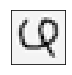

In [6]:
plot_an_image(X[1242])

In [7]:
def plot_100_images(X):
    size = int(np.sqrt(X.shape[1]))
    
    sample_idx = np.random.choice(np.arange(X.shape[0]), 100)
    sample_images = X[sample_idx, :]
    
    fig, ax_array = plt.subplots(nrows=10, ncols=10, sharex=True, sharey=True, figsize=(8,8))
    
    for r in range(10):
        for c in range(10):
            ax_array[r, c].matshow(sample_images[10 * r + c].reshape(size, size), cmap = matplotlib.cm.binary)
            plt.xticks(np.array([]))
            plt.yticks(np.array([]))   

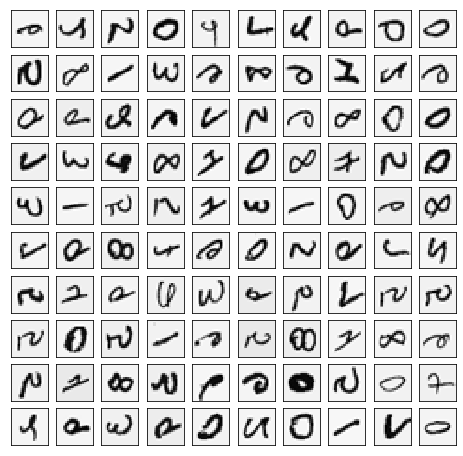

In [8]:
plot_100_images(X)
plt.show()

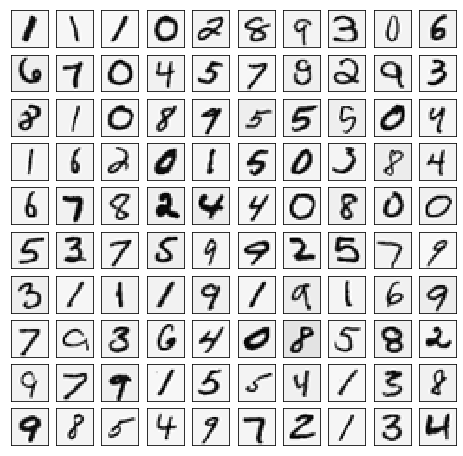

In [9]:
X, _ = load_data('ex4data1.mat', True)
plot_100_images(X)
plt.show()

In [10]:
X_raw, y_raw = load_data('ex4data1.mat')
X = np.insert(X_raw, 0, np.ones(X_raw.shape[0]), axis=1)
X.shape

(5000, 401)

In [11]:
y_raw.shape, y_raw, np.unique(y_raw)

((5000,),
 array([10, 10, 10, ...,  9,  9,  9], dtype=uint8),
 array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=uint8))

## 向量标签化

In [12]:
def expand_y(y):
    """expand 5000*1 into 5000*10
    where y=10 -> [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]: ndarray
    """
    result = []
    for k in range(1,11):
        result.append((y==k).astype(int))
    return np.array(result).T

In [13]:
y = expand_y(y_raw)
y

array([[0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1],
       ...,
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 1, 0]])

# Get weight

In [14]:
def load_weight(path):
    data = sio.loadmat(path)
    return data['Theta1'], data['Theta2']

In [15]:
t1, t2 = load_weight('ex4weights.mat')
t1.shape, t2.shape

((25, 401), (10, 26))

In [16]:
def serialize(t1, t2):
    return np.concatenate((np.ravel(t1), np.ravel(t2)))

In [17]:
theta = serialize(t1, t2)
theta.shape

(10285,)

# Foward propagation 

> 400 + 1  --->  25 + 1 ---> 10

![fp](./images/nn_model.png)

In [18]:
def deserialilze(seq):
    return seq[:25 * 401].reshape(25, 401), seq[25*401:].reshape(10,26)

In [19]:
def sigmoid(z):
    return 1 / (1+np.exp(-z))

In [144]:
def forward_propagation(theta, X):
    t1, t2 = deserialilze(theta)
    m = X.shape[0]
    a1 = X  # 在上面已经加过一次，此处不增加: 5000 * 401
    
    z2 = a1 @ t1.T  # 5000 * 401 @ 401 * 25 => 5000 * 25
    a2 = np.insert(sigmoid(z2), 0, np.ones(m), axis=1)   # 5000 * 26
    
    z3 = a2 @ t2.T  # 5000 * 26 @ 26 * 10 => 5000 * 10
    h = sigmoid(z3)
    
    return a1, z2, a2, z3, h

In [21]:
result = forwad_propagation(theta, X)
final_res = result[-1]

In [22]:
final_res.shape, final_res

((5000, 10), array([[1.12661530e-04, 1.74127856e-03, 2.52696959e-03, ...,
         4.01468105e-04, 6.48072305e-03, 9.95734012e-01],
        [4.79026796e-04, 2.41495958e-03, 3.44755685e-03, ...,
         2.39107046e-03, 1.97025086e-03, 9.95696931e-01],
        [8.85702310e-05, 3.24266731e-03, 2.55419797e-02, ...,
         6.22892325e-02, 5.49803551e-03, 9.28008397e-01],
        ...,
        [5.17641791e-02, 3.81715020e-03, 2.96297510e-02, ...,
         2.15667361e-03, 6.49826950e-01, 2.42384687e-05],
        [8.30631310e-04, 6.22003774e-04, 3.14518512e-04, ...,
         1.19366192e-02, 9.71410499e-01, 2.06173648e-04],
        [4.81465717e-05, 4.58821829e-04, 2.15146201e-05, ...,
         5.73434571e-03, 6.96288990e-01, 8.18576980e-02]]))

In [23]:
prediction = (final_res>=.5).astype(int)

In [24]:
print(classification_report(y, prediction))

              precision    recall  f1-score   support

           0       0.99      0.97      0.98       500
           1       0.99      0.93      0.96       500
           2       0.98      0.90      0.94       500
           3       0.98      0.94      0.96       500
           4       1.00      0.95      0.97       500
           5       1.00      0.96      0.98       500
           6       0.98      0.95      0.96       500
           7       0.99      0.93      0.96       500
           8       0.98      0.93      0.96       500
           9       1.00      0.98      0.99       500

   micro avg       0.99      0.95      0.97      5000
   macro avg       0.99      0.95      0.97      5000
weighted avg       0.99      0.95      0.97      5000
 samples avg       0.94      0.95      0.94      5000



C:\Users\Administrator\Anaconda3\envs\nlp\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


# Cost function
![nn cost function](../img/nn_cost.png)

think about this, now we have $y$ and $h_{\theta} \in R^{5000 \times 10}$  
If you just ignore the m and k dimention, pairwisely this computation is trivial.  
the eqation $= -y*log(h_{\theta}) - (1-y)*log(1-h_{\theta})$  
all you need to do after pairwise computation is sums this 2d array up and divided by m

In [25]:
def cost(theta, X, y):
    m = X.shape[0]
    h = forwad_propagation(theta, X)[-1]
    pair_computation = -np.multiply(y, np.log(h))  - np.multiply((1 - y), np.log(1-h))
    return pair_computation.sum() / m

In [26]:
cost(theta, X, y)

0.2876291651613189

## Regularized function
![regularized function](../img/nn_regcost.png)

In [129]:
def regularized_cost(theta, X, y, lambda_=1):
    """the first column of t1 and t2 is intercept theta, ignore them when you do regularization"""
    t1, t2 = deserialilze(theta)
    m = X.shape[0]
    
    reg_t1 = (lambda_ / (2 * m)) * np.power(t1[:, 1:], 2).sum()  # ignore first column
    reg_t2 = (lambda_ / (2 * m)) * np.power(t2[:, 1:], 2).sum()
    
    return cost(theta, X, y) + reg_t1 + reg_t2

In [28]:
regularized_cots(theta, X, y)

0.38376985909092365

# Back propagation
- [Video](https://study.163.com/course/courseLearn.htm?courseId=1004570029#/learn/video?lessonId=1051774858&courseId=1004570029)

![1](./images/1.png)
![2](./images/2.png)
![3](./images/3.png)

In [29]:
X.shape, y.shape, t1.shape, t2.shape, theta.shape

((5000, 401), (5000, 10), (25, 401), (10, 26), (10285,))

In [30]:
# sigmoid函数的导数
def sigmoid_gradient(z):
    return sigmoid(z) * (1 - sigmoid(z))

In [31]:
# 0.5 * (1-0.5)
sigmoid_gradient(0)

0.25

## theta gradient

In [81]:
def gradient(theta, X, y):
    t1, t2 = deserialilze(theta)  # (25, 401) (10, 26)
    m = X.shape[0]
    
    delta1 = np.zeros(t1.shape)  # (25, 401)
    delta2 = np.zeros(t2.shape)  # (10, 26)
    
    a1, z2, a2, z3, h = forwad_propagation(theta, X)
    
    for i in range(m):
        a1_i = a1[i, :]  # (1, 401)
        z2_i = z2[i, :]  # (1, 25)
        a2_i = a2[i, :]  # (1, 26)
        
        h_i = h[i, :]  # (1, 10)
        y_i = y[i, :]  # (1, 10)
        
        d3_i = h_i - y_i  # (1, 10)
        
        z2_i = np.insert(z2_i, 0, np.ones(1))  # (1, 26)
        d2_i = (t2.T @ d3_i) * sigmoid_gradient(z2_i)  # (1, 26)
        
        delta2 += np.matrix(d3_i).T @ np.matrix(a2_i)
        delta1 += np.matrix(d2_i[1:]).T @ np.matrix(a1_i)
        
        
    delta1 = delta1 / m
    delta2 = delta2 / m
    
    return serialize(delta1, delta2)

In [82]:
d1, d2 = deserialilze(gradient(theta, X, y))

In [83]:
d1.shape, d2.shape

((25, 401), (10, 26))

# Gradient check
![gradient check](../img/gradient_checking.png)

## regularized gradient
Use normal gradient + regularized term

<img style="float: left;" src="../img/nn_reg_grad.png">

In [135]:
def regularized_gradient(theta, X, y, l=1):
    """don't regularize theta of bias terms"""
    m = X.shape[0]
    delta1, delta2 = deserialilze(gradient(theta, X, y))
    t1, t2 = deserialilze(theta)

    t1[:, 0] = 0
    reg_term_d1 = (l / m) * t1
    delta1 = delta1 + reg_term_d1

    t2[:, 0] = 0
    reg_term_d2 = (l / m) * t2
    delta2 = delta2 + reg_term_d2

    return serialize(delta1, delta2)

In [130]:
def gradient_check(theta, X, y, epsilon, regularized=False):
    def a_numeric_grad(plus, minus, regularized=False):
        """Calculate a partial gradient with respect to 1 theta"""
        if regularized:
            return (regularized_cost(plus, X, y) - regularized_cost(minus, X, y)) / (epsilon * 2)
        else:
            return (cost(plus, X, y) - cost(minus, X, y)) / (epsilon * 2)
    
    theta_matrix = expand_y(theta)
    epsilon_matrix = np.identity(len(theta)) * epsilon
    
    plus_matrix = theta_matrix + epsilon_matrix
    minus_matrix = theta_matrix - epsilon_matrix
    
    # calculate numerical gradient with respect to all theta
    numeric_grad = np.array([a_numeric_grad(plus_matrix[i], minus_matrix[i], regularized)
                            for i in range(len(theta))])
    
    # analytical grad will depend on if you want it to be regularized or not
    analytic_grad = regularized_gradient(theta, X, y) if regularized else gradient(theta, X, y)
    
    # If you have a correct implementation, and assuming you used EPSILON = 0.0001
    # the diff below should be less than 1e-9
    # this is how original matlab code do gradient checking
    diff = np.linalg.norm(numeric_grad - analytic_grad) / np.linalg.norm(numeric_grad + analytic_grad)
    
    print('If your backpropagation implementation is correct,\nthe relative difference will be smaller than 10e-9 (assume epsilon=0.0001).\nRelative Difference: {}\n'.format(diff))

In [119]:
def expand_array(arr):
    """replicate array into matrix
    [1, 2, 3]

    [[1, 2, 3],
     [1, 2, 3],
     [1, 2, 3]]
    """
    # turn matrix back to ndarray
    return np.array(np.repeat(arr, arr.shape[0], axis=0))
#     return np.array(np.matrix(np.ones(arr.shape[0])).T @ np.matrix(arr))

In [50]:
gradient_checking(theta, X, y, epsilon= 0.0001)#这个运行很慢，谨慎运行

If your backpropagation implementation is correct,
the relative difference will be smaller than 10e-9 (assume epsilon=0.0001).
Relative Difference: 2.1455623285988868e-09



In [53]:
gradient_checking(theta, X, y, epsilon=0.0001, regularized=True)#这个运行很慢，谨慎运行

If your backpropagation implementation is correct,
the relative difference will be smaller than 10e-9 (assume epsilon=0.0001).
Relative Difference: 3.1905824084956572e-09



# Training a neural network
- 1.随机选择初始值
- 2.前向传播得到 $h_\theta(x^{(i)})$
- 3.得到代价函数
- 4.后向传播得到代价函数的偏导数
- 5.梯度检验
- 6.应用梯度下降或者其他调优方法通过后向传播使得代价函数最小，得到最小代价函数的 $\theta$

 remember to randomly initlized the parameters to break symmetry

take a look at the doc of this argument: `jac`

>jac : bool or callable, optional
Jacobian (gradient) of objective function. Only for CG, BFGS, Newton-CG, L-BFGS-B, TNC, SLSQP, dogleg, trust-ncg. **If jac is a Boolean and is True, fun is assumed to return the gradient along with the objective function.** If False, the gradient will be estimated numerically. jac can also be a callable returning the gradient of the objective. In this case, it must accept the same arguments as fun.

it means if your `backprop` function return `(cost, grad)`, you could set `jac=True`  

This is the implementation of http://nbviewer.jupyter.org/github/jdwittenauer/ipython-notebooks/blob/master/notebooks/ml/ML-Exercise4.ipynb

but I choose to seperate them

In [128]:
def random_init(size):
    return np.random.uniform(-.12, .12, size)

In [131]:
def nn_training(X, y):
    init_theta = random_init(10285)  # 25 * 401 + 10 * 26
    
    result = opt.minimize(fun=regularized_cost,
                         x0=init_theta,
                         args=(X, y),
                         method='TNC',
                         jac=regularized_gradient,
                         options={'maxiter': 400})
    return result

In [136]:
# 很慢
result = nn_training(X, y)

In [137]:
_, y_answer = load_data('ex4data1.mat')
final_theta = result.x

In [142]:
def show_accuracy(theta, X, y):
    result = forward_propagation(theta, X)
    h = result[-1]
    y_pred = np.argmax(h, axis=1) + 1
    print(classification_report(y, y_pred))

In [151]:
show_accuracy(theta, X, y_answer)

              precision    recall  f1-score   support

           1       0.97      0.98      0.98       500
           2       0.98      0.97      0.98       500
           3       0.98      0.96      0.97       500
           4       0.97      0.97      0.97       500
           5       0.97      0.98      0.98       500
           6       0.98      0.99      0.98       500
           7       0.98      0.97      0.97       500
           8       0.98      0.98      0.98       500
           9       0.97      0.96      0.96       500
          10       0.98      0.99      0.99       500

    accuracy                           0.98      5000
   macro avg       0.98      0.98      0.98      5000
weighted avg       0.98      0.98      0.98      5000



In [154]:
def plot_hidden_layer(theta):
    final_theta1, _ = deserialilze(theta)
    hidden_layer = final_theta1[:, 1:]  # get rid of bias term theta
    
    fig, axes = plt.subplots(5, 5, sharey=True, sharex=True, figsize=(5,5))
    
    for i, ax in enumerate(axes.flat):
        ax.matshow(hidden_layer[i].reshape(20, 20), cmap=matplotlib.cm.binary)
        ax.set_xticks([])
        ax.set_yticks([])

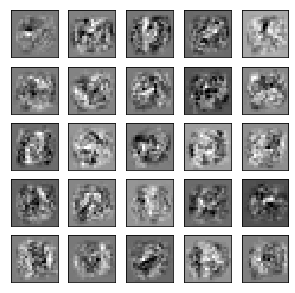

In [155]:
plot_hidden_layer(final_theta)
plt.show()